In [1]:
import dataloader
import sys
import time
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import gc

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed, Flatten

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

%load_ext autoreload
%autoreload 2

path = "../032721Comparison/Data/IBIO2021.csv"
date = datetime.datetime(2021,3,12)
count = 1200
# We will use the previous 60 days as features
history_size = 60

In [2]:
# Compute MAE
def mae(y_hat, y):
    # mean absolute error
    return np.abs(y_hat - y).mean()

def rmse(y_hat, y):
    # root mean squared error
    return np.sqrt(np.mean(np.power((y-y_hat),2)))

In [3]:
df = dataloader.load_data_up_to_date(path, date, count)

(1258, 7)
(1257, 7)
(1257, 7)
(1200, 7)


In [4]:
ibio_closing_all = df['Close'].to_numpy()
# reshape to 1200 x 1 matrix
ibio_closing_all = np.reshape(ibio_closing_all, (ibio_closing_all.shape[0], -1))
ibio_closing_all.shape

(1200, 1)

In [5]:
#converting prices to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ibio_closing_all)
train = scaled_data[:1000,:]
test = scaled_data[1000:, :]

In [6]:
train_x, train_y = [], []
test_x, test_y = [], []
for i in range(history_size,len(train)):
    train_x.append(scaled_data[i-history_size:i,0])
    train_y.append(scaled_data[i,0])
train_x, train_y = np.array(train_x), np.array(train_y)

train_x = np.reshape(train_x, (train_x.shape[0],train_x.shape[1], 1))
print(train_x.shape)

for i in range(len(train),len(scaled_data)):
    test_x.append(scaled_data[i-history_size:i,0])
    test_y.append(scaled_data[i,0])
test_x, test_y = np.array(test_x), np.array(test_y)

test_x = np.reshape(test_x, (test_x.shape[0],test_x.shape[1], 1))
print(test_x.shape)

(940, 60, 1)
(200, 60, 1)


In [7]:
# How many features do we want to pass as hidden unit
UNITS = range(2, 60, 2)
K = 5
model = None
gc.collect()

best_unit_count = None
# Best Validation Error
best_err = sys.maxsize

for unit_count in UNITS:
    kf = KFold(n_splits=K, random_state=None, shuffle=False)
    y_err = []
    
    
    # Cross Validaiton
    for train_index, val_index in kf.split(train_x):
        X_train, X_val = train_x[train_index], train_x[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]
    
        model = Sequential()
        model.add(LSTM(units=unit_count, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(RepeatVector(X_train.shape[1]))
        model.add(LSTM(units=unit_count, return_sequences=True))
        model.add(Flatten())
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)
        y_hat = model.predict(X_val).transpose()[0]
        del model
        gc.collect()
        
        y_err.append(rmse(y_hat, y_val))
        
    print(str(unit_count), "mean val RMSE:", np.mean(y_err))

    if np.mean(y_err) < best_err:
        best_err = np.mean(y_err)
        best_unit_count = unit_count

print(best_unit_count, best_err)

2 mean val RMSE: 0.1695527516544703
4 mean val RMSE: 0.1207422526811073
6 mean val RMSE: 0.12250150351904994
8 mean val RMSE: 0.036986301494054866
10 mean val RMSE: 0.053454451452240384
12 mean val RMSE: 0.043198136102625934
14 mean val RMSE: 0.03874958213316978
16 mean val RMSE: 0.03657039564989746
18 mean val RMSE: 0.027976429192305287
20 mean val RMSE: 0.040798724830225994
22 mean val RMSE: 0.03675098614616553
24 mean val RMSE: 0.04320429051123915
26 mean val RMSE: 0.044935996806237735
28 mean val RMSE: 0.048373748662458096
30 mean val RMSE: 0.049380157873924094
32 mean val RMSE: 0.04832150674124146
34 mean val RMSE: 0.03881522078699112
36 mean val RMSE: 0.02673193263871651
38 mean val RMSE: 0.034495459546801374
40 mean val RMSE: 0.03325002077638231
42 mean val RMSE: 0.032892587071638765
44 mean val RMSE: 0.029920941533232503
46 mean val RMSE: 0.042485888976134104
48 mean val RMSE: 0.0433550797075047
50 mean val RMSE: 0.029568411122440796
52 mean val RMSE: 0.03148718747768534
54 mea

In [8]:
model = None
gc.collect()

model = Sequential()
model.add(LSTM(units=best_unit_count, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(units=best_unit_count, return_sequences=True))
model.add(Flatten())
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs=100, batch_size=32, verbose=1)
print(model.summary())
y_hat = model.predict(test_x).transpose()[0]

del model
gc.collect()

Epoch 1/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0127
Epoch 2/100
30/30 [==============================] - 0s 11ms/step - loss: 7.8710e-04
Epoch 3/100
30/30 [==============================] - 0s 12ms/step - loss: 6.1758e-04
Epoch 4/100
30/30 [==============================] - 0s 12ms/step - loss: 6.3593e-04
Epoch 5/100
30/30 [==============================] - 0s 12ms/step - loss: 6.2805e-04
Epoch 6/100
30/30 [==============================] - 0s 12ms/step - loss: 6.0137e-04
Epoch 7/100
30/30 [==============================] - 0s 12ms/step - loss: 5.7779e-04
Epoch 8/100
30/30 [==============================] - 0s 12ms/step - loss: 5.8200e-04
Epoch 9/100
30/30 [==============================] - 0s 12ms/step - loss: 6.5305e-04
Epoch 10/100
30/30 [==============================] - 0s 12ms/step - loss: 5.6359e-04
Epoch 11/100
30/30 [==============================] - 0s 12ms/step - loss: 5.2241e-04
Epoch 12/100
30/30 [==============================] - 0s 12ms/step -

30/30 [==============================] - 0s 12ms/step - loss: 5.1099e-04
Epoch 97/100
30/30 [==============================] - 0s 12ms/step - loss: 4.8617e-04
Epoch 98/100
30/30 [==============================] - 0s 12ms/step - loss: 6.0755e-04
Epoch 99/100
30/30 [==============================] - 0s 12ms/step - loss: 4.4692e-04
Epoch 100/100
30/30 [==============================] - 0s 12ms/step - loss: 4.4618e-04
Model: "sequential_145"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_290 (LSTM)              (None, 36)                5472      
_________________________________________________________________
repeat_vector_145 (RepeatVec (None, 60, 36)            0         
_________________________________________________________________
lstm_291 (LSTM)              (None, 60, 36)            10512     
_________________________________________________________________
flatten_145 (Flatten)        (

39010

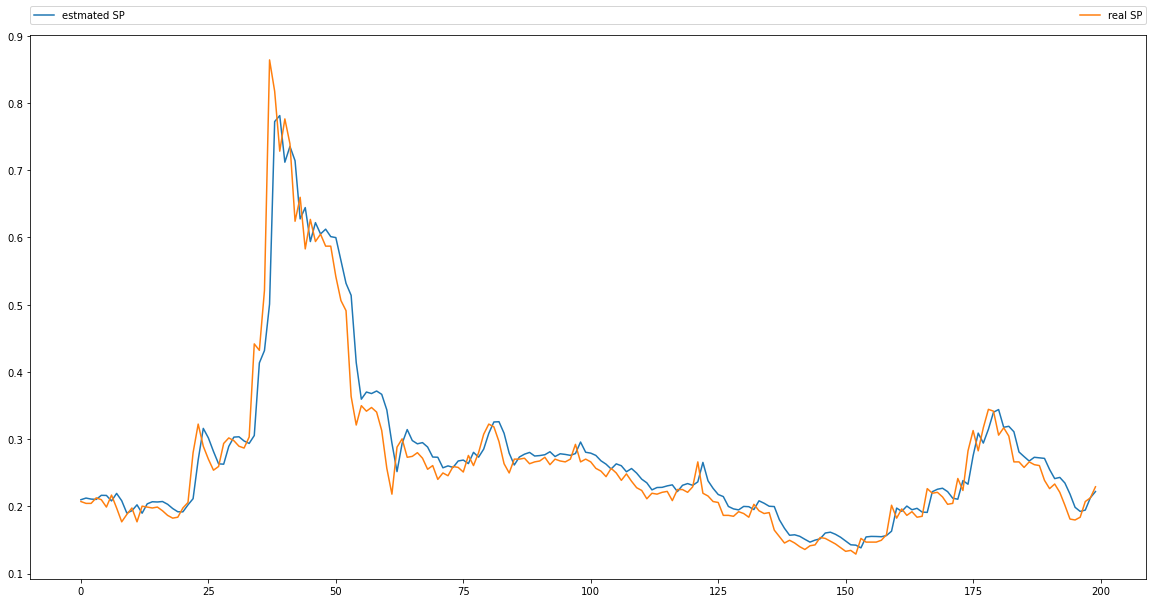

In [9]:
plt.plot(y_hat[:], label="estmated SP")
plt.plot(test_y[:], label="real SP")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [10]:
print("MAE:  ", mae(y_hat, test_y))
print("RMSE: ", rmse(y_hat, test_y))

MAE:   0.022324710795745273
RMSE:  0.03926165760540114
